In [1]:
%load_ext autoreload
%autoreload 2
import datetime
from glob import glob
import os
from pathlib import Path
import math
import numpy as np
import pandas as pd
import sys
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename
from train_prophet import main_prophet
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [99]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET]

train_paths = glob('../feature/raw_main/*_train.gz')
test_paths = glob('../feature/raw_main/*_test.gz')

train_paths = [path for path in train_paths if path.count('DT') or path.count('day_no') or path.count('Amt')]
test_paths  = [path for path in test_paths  if path.count('DT') or path.count('day_no') or path.count('Amt')]

train_df = parallel_load_data(train_paths)
test_df = parallel_load_data(test_paths)
event_df = pd.read_csv('../input/usa_event_calendar.csv')
event_df['date'] = event_df['date'].map(lambda x: datetime.date(*[int(d) for d in x.split('-')]))
event_df.set_index('date', inplace=True)

In [125]:
indicator = 'TransactionAmt'
df_list = []
for i in range(20):
# for i in range(4):
    if i+1<10:
        START_DATE = f'2017-11-0{i+1}'
    else:
        START_DATE = f'2017-11-{i+1}'
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    
    train_df['datetime'] = train_df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    test_df['datetime'] = test_df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    
    train_df['month'] = train_df['datetime'].map(lambda x: x.month)
    test_df['month']  =  test_df['datetime'].map(lambda x: x.month)
    train_df['date'] = train_df['datetime'].map(lambda x: x.date())
    test_df['date']  =  test_df['datetime'].map(lambda x: x.date())
    
    train = train_df[['month', 'date', 'TransactionAmt']]
    test  = test_df[ ['month', 'date', 'TransactionAmt']]
    data = pd.concat([train, test], axis=0)
#     data = data[data['month']>=10]
    
    tmp = data.groupby('date')[indicator].count()
    amt = data.groupby('date')[indicator].sum()
    
    tmp = (tmp-tmp.mean())/tmp.std()
    tmp = tmp.to_frame('Transaction_cnt')
    amt = (amt-amt.mean())/amt.std()
    amt = amt.to_frame('Transaction_sum')
    data = tmp.join(amt)
    
    data['start_date'] = startdate
#     data = data.join(event_df, how='inner')
    data = data.join(event_df, how='left')
    
    df_list.append(data)
    
df = pd.concat(df_list, axis=0)

In [132]:
viz = df.reset_index()
viz['dow'] = viz['date'].map(lambda x: x.weekday())
# For Tableau
# tmp = viz.groupby(['event', 'start_date'])[COLUMN_VIZ].mean().reset_index()
# tmp = viz.groupby(['event', 'start_date'])[COLUMN_VIZ].max().reset_index()
viz.to_csv('../eda/eda_start_date_by_event.csv', index=False)

2017-11-22
2017-11-23
2017-11-24
2017-11-25
2017-11-26
2017-11-27
2017-11-28
2017-11-29
2017-11-30
2017-12-01
2017-12-02
2017-12-03


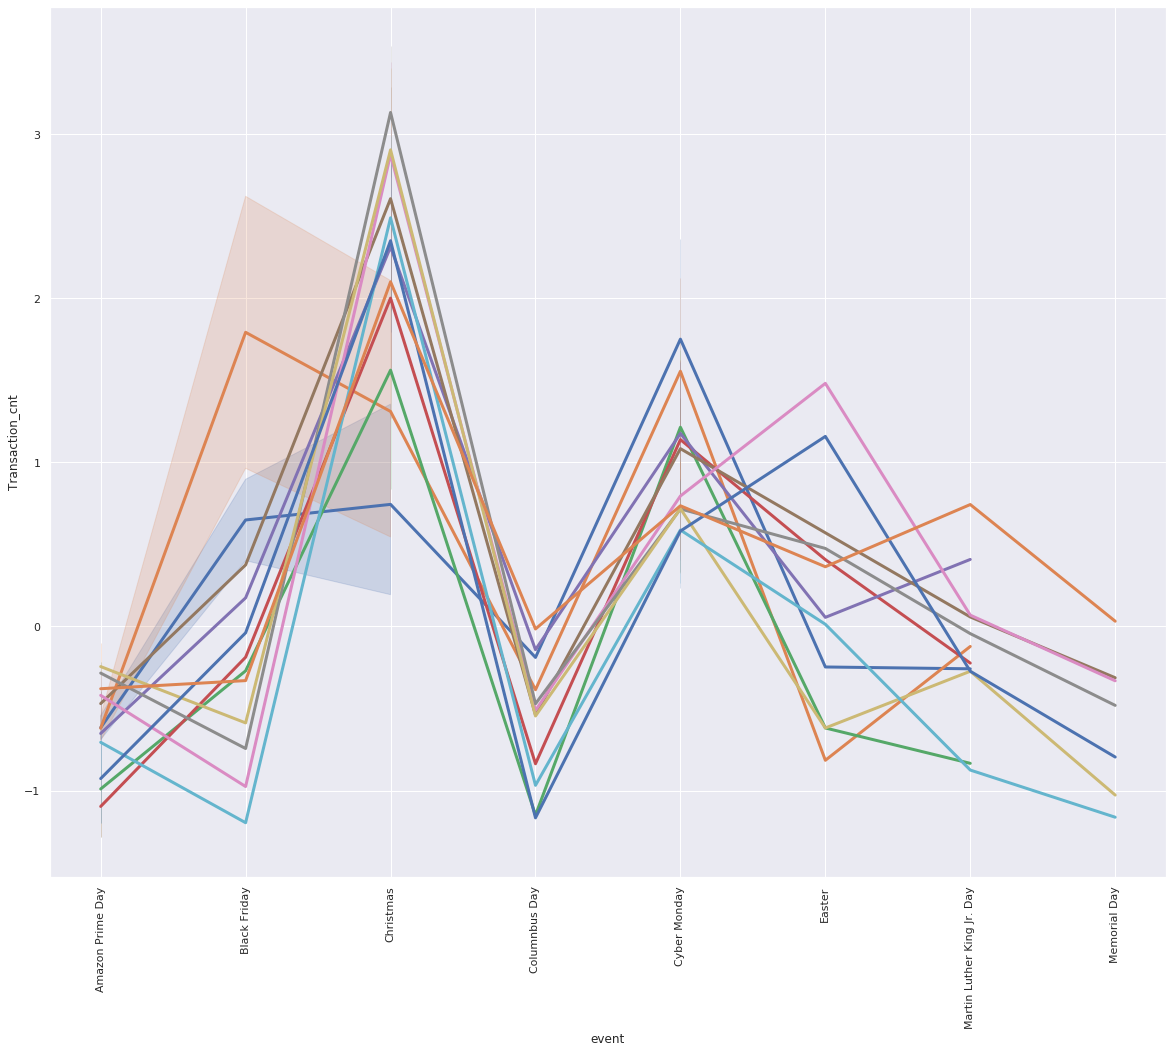

In [65]:
list_event = viz['event'].unique()
COLUMN_VIZ = 'Transaction_cnt'
sns.set_style('whitegrid')
sns.set()
plt.figure(figsize=(20, 16))

# for event in list_event:
for START_DATE in START_DATE_LIST:
#     print(event)
#     tmp = viz[viz['event']==event]
    print(START_DATE)
    tmp = viz[viz['start_date']==START_DATE]
    tmp = tmp.groupby(['date', 'event'])[COLUMN_VIZ].mean().reset_index()
    
#     sns.lineplot(data=tmp, x='date', y =COLUMN_VIZ, hue='start_date', lw="3")
    sns.lineplot(data=tmp, x='event', y =COLUMN_VIZ, lw="3")
plt.xticks(rotation='vertical')
plt.show()

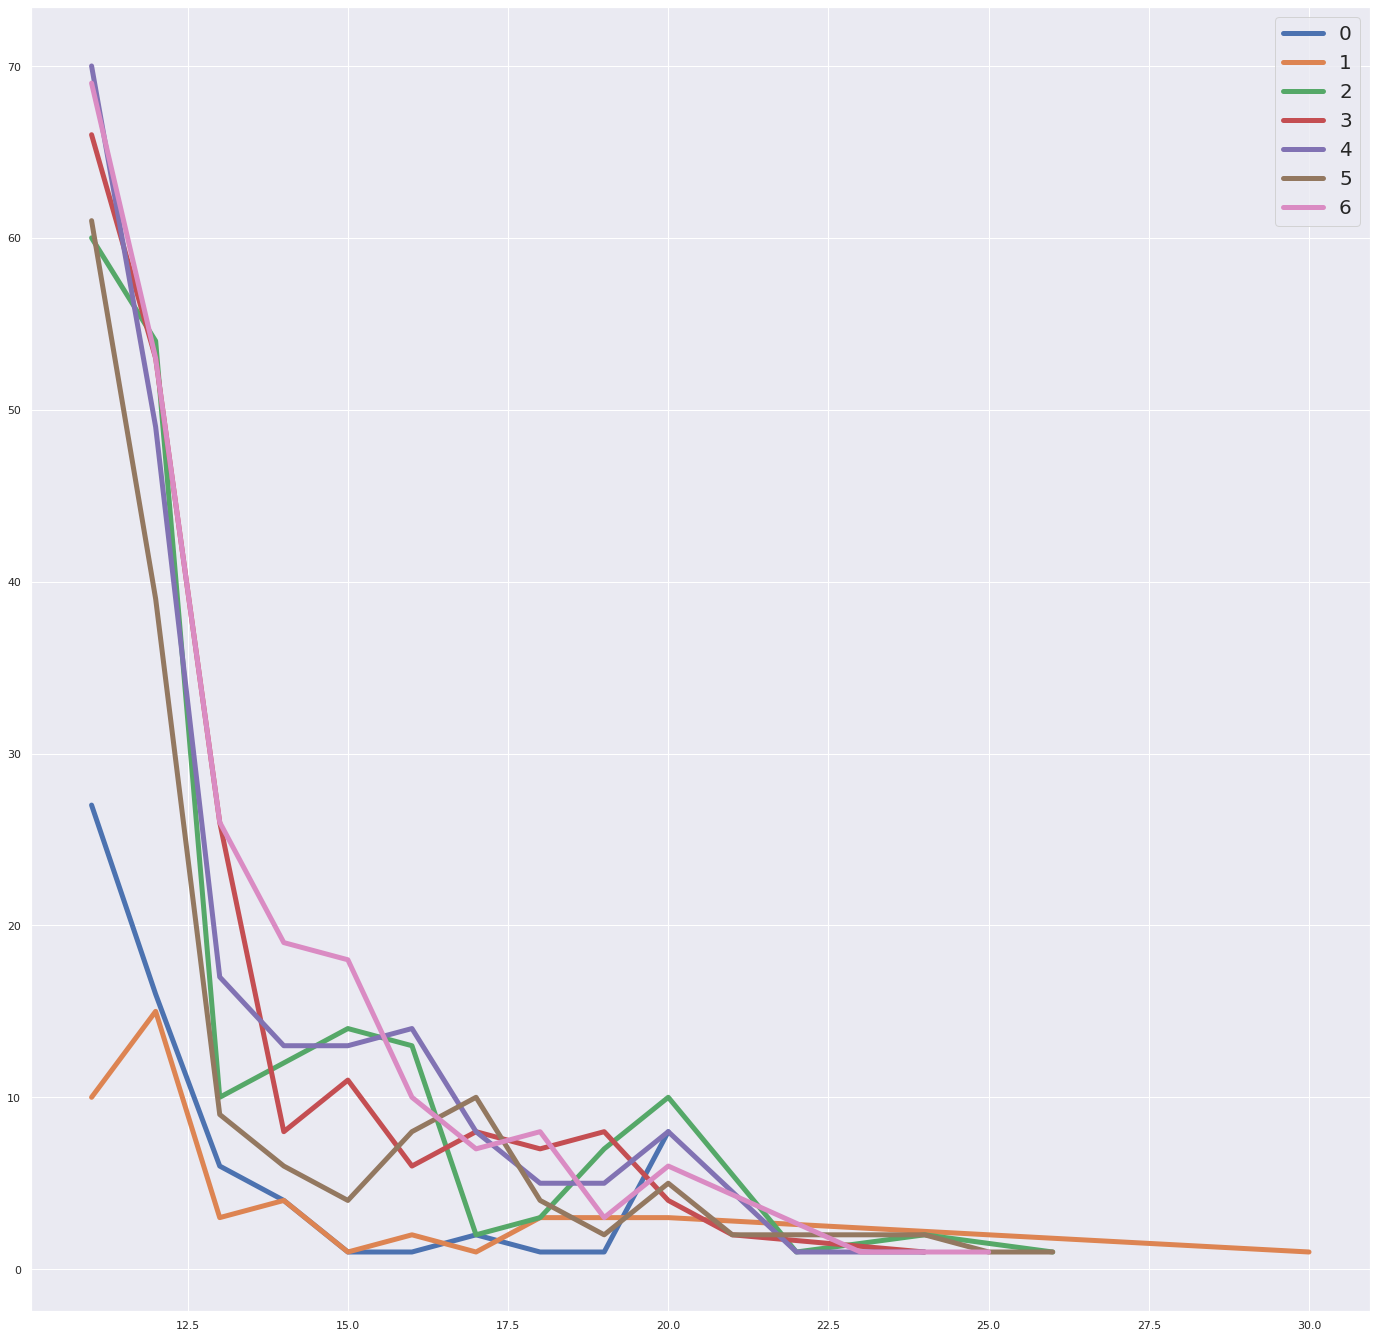

In [29]:
viz_list = []
plt.figure(figsize=(24, 24))
for dow in dow_list:
    df = tmp[tmp['dow']==dow]
    viz = df[indicator].value_counts().sort_index().reset_index()
    viz = viz[viz['index']>10]
    viz = viz[viz['index']<35]
    viz['dow'] = dow
    
    sns.set()
    fig = plt.plot(viz['index'], viz[indicator], label=dow, lw=5)
#     viz_list.append(viz)
# viz = pd.concat(viz_list, axis=0)
# plt.plot(viz['index'], viz[indicator])
plt.legend(fontsize=20)
plt.show()

In [33]:
indicator ='transaction_cnt' 

train = train_df.groupby('date')['date'].count()
train.name = indicator
test = test_df.groupby('date')['date'].count()
test.name = indicator

data = pd.concat([train, test], axis=0)

In [37]:
tmp = (data - data.mean())/data.std()
tmp.tail(60)

date
2018-10-27    0.736038
2018-10-28    0.779415
2018-10-29   -0.339723
2018-10-30   -0.876363
2018-10-31   -0.197197
2018-11-01   -0.352116
2018-11-02   -0.577679
2018-11-03   -0.737556
2018-11-04   -0.146383
2018-11-05   -0.721444
2018-11-06   -1.172569
2018-11-07   -0.679306
2018-11-08   -0.546695
2018-11-09   -0.365749
2018-11-10   -0.136468
2018-11-11    0.136190
2018-11-12   -0.345919
2018-11-13   -0.821832
2018-11-14    0.034563
2018-11-15   -0.329808
2018-11-16   -0.038559
2018-11-17   -1.196117
2018-11-18   -0.587594
2018-11-19   -0.743752
2018-11-20   -0.975512
2018-11-21    0.375385
2018-11-22    0.174610
2018-11-23   -0.187282
2018-11-24   -0.270319
2018-11-25    0.964079
2018-11-26    0.401412
2018-11-27   -0.089373
2018-11-28    1.437513
2018-11-29    1.034722
2018-11-30    0.211791
2018-12-01    0.239056
2018-12-02    0.773218
2018-12-03    0.099009
2018-12-04   -0.282712
2018-12-05    0.607145
2018-12-06    0.749671
2018-12-07    0.555092
2018-12-08    0.464619
2018-1

In [ ]:
for col in ['day_no', 'hour', 'time_zone', 'month']:
    feature = train_df[col].values
    to_pkl_gzip(obj=feature, path=f'../feature/raw_main/{col}_train')

for col in ['day_no', 'hour', 'time_zone', 'month']:
    feature = test_df[col].values
    to_pkl_gzip(obj=feature, path=f'../feature/raw_main/{col}_test')

In [96]:
START_DATE = '2017-12-01'

for START_DATE in [
    '2017-11-25',
#     '2017-11-29',
#     '2017-11-30',
#     '2017-12-01',
]:

    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    train_df['datetime'] = train_df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    test_df['datetime'] = test_df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    
    train_df['date'] = train_df['datetime'].map(lambda x: x.date())
    test_df['date']  =  test_df['datetime'].map(lambda x: x.date())
    
    train = train_df.groupby('date')['date'].count()
    train.name = 'transaction_cnt'
    test = test_df.groupby('date')['date'].count()
    test.name = 'transaction_cnt'
    train = train.reset_index()
    test = test.reset_index()
    train['day_of_week'] = train['date'].map(lambda x: x.weekday())
    test['day_of_week'] = test['date'].map(lambda x: x.weekday())
    train = pd.concat([train, test], axis=0, ignore_index=True)
    
    train['month'] = train['date'].map(lambda x: x.month)
    test['month'] = test['date'].map(lambda x: x.month)
    train = train[train['month']!=11]
    train = train[train['month']!=12]
    train = train[train['month']!=1]
    train = train[train['month']!=3]
    print(train['month'].value_counts())
    
    pred_period = 200
    trend_term = 'monthly'
    TARGET = 'transaction_cnt'
    
    pred_df = main_prophet(
        train = train,
        test = [],
        COLUMN_TARGET = TARGET,
        ADD_FEATURES = [],
        pred_period = pred_period,
        trend_term = trend_term,
        is_viz = False,
        is_score = False,
        holidays=[],
    )
    display(pred_df.groupby('day_of_week')['weekly'].max())

10    31
8     31
7     31
9     30
4     30
2     28
5     26
6      5
Name: month, dtype: int64


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


day_of_week
0.0   -238.002966
1.0   -498.714017
2.0     77.571352
3.0    120.962994
4.0    101.196135
5.0     70.491257
6.0    366.495245
Name: weekly, dtype: float64